In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

torch.set_printoptions(linewidth=120) # display options for output
torch.set_grad_enabled(True)

In [2]:
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

In [3]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
        
        self.fc1 = nn.Linear(in_features=12*4*4, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=60)
        self.out = nn.Linear(in_features=60, out_features=10)
        
    def forward(self, t):
        
        
        # (2) hidden conv layer
        
        t = F.relu(self.conv1(t))
        t = F.max_pool2d(t, kernel_size = 2, stride = 2)
        
        # (3) hidden conv layer
        
        t = F.relu(self.conv2(t))
        t = F.max_pool2d(t, kernel_size = 2, stride = 2)
        
        # (4) hidden linear layer
        t = t.reshape(-1, 12 * 4 * 4)
        
        t = F.relu(self.fc1(t))
        
        # (5) hidden linear layer
        
        t = F.relu(self.fc2(t))
        
        # (6) output layer
        t = self.out(t)
        #t = F.softmax(t,dim = 1)
        
        return t

In [4]:
train_set = torchvision.datasets.FashionMNIST(
    root='./data/FashionMNIST'
    ,train=True
    ,download=True
    ,transform=transforms.Compose([
        transforms.ToTensor()
    ])
)

In [5]:
network = Network()

In [6]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=100)

In [7]:
optimizer = optim.Adam(network.parameters(), lr = 0.01)

In [8]:
for epoch in range(5):
    
    total_loss = 0
    total_correct = 0
    
    for batch in train_loader: # Get Batch
        images, labels = batch
    
        preds = network(images) # pass Batch
        loss = F.cross_entropy(preds, labels) # Calculate Loss
    
        optimizer.zero_grad()
        loss.backward() # calculate Gradients
        optimizer.step() # Update Weights
    
        total_loss += loss.item()
        total_correct += get_num_correct(preds, labels)
    
    print("epoch:", epoch, "total_correct:", total_correct, "loss:", total_loss)

epoch: 0 total_correct: 46501 loss: 352.4016133248806
epoch: 1 total_correct: 51207 loss: 239.29294101893902
epoch: 2 total_correct: 51742 loss: 224.25354616343975
epoch: 3 total_correct: 52170 loss: 213.36851394176483
epoch: 4 total_correct: 52323 loss: 208.40046115219593


In [9]:
len(train_set)

60000

In [10]:
len(train_set.targets)

60000

# Getting predictions for the entire training set

In [11]:
@torch.no_grad() # omit gradient tracking, method 1 
def get_all_preds(model, loader):
    all_preds = torch.tensor([])
    for batch in loader:
        images, labels = batch

        preds = model(images)
        all_preds = torch.cat(
            (all_preds, preds)
            ,dim=0
        )
    return all_preds

In [12]:
with torch.no_grad(): # omit gradient tracking, method 2
    prediction_loader = torch.utils.data.DataLoader(train_set, batch_size=10000)
    train_preds = get_all_preds(network, prediction_loader)    

In [13]:
train_preds.shape

torch.Size([60000, 10])

In [14]:
print(train_preds.requires_grad)

False


In [15]:
train_preds.grad

In [16]:
train_preds.grad_fn

In [17]:
preds_correct = get_num_correct(train_preds, train_set.targets)

print('total correct:', preds_correct)
print('accuracy:', preds_correct / len(train_set))

total correct: 52497
accuracy: 0.87495


# Building a confusion matrix

In [18]:
train_set.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

In [19]:
train_set.targets.shape

torch.Size([60000])

In [20]:
train_preds.argmax(dim=1)

tensor([9, 0, 0,  ..., 3, 0, 5])

In [21]:
train_preds.argmax(dim=1).shape

torch.Size([60000])

In [22]:
stacked = torch.stack(
    (
        train_set.targets
        ,train_preds.argmax(dim=1)
    )
    ,dim=1
)

In [23]:
stacked.shape

torch.Size([60000, 2])

In [24]:
stacked

tensor([[9, 9],
        [0, 0],
        [0, 0],
        ...,
        [3, 3],
        [0, 0],
        [5, 5]])

In [25]:
stacked[0].tolist()

[9, 9]

In [26]:
j, k = stacked[0].tolist()

In [27]:
j

9

In [28]:
k

9

In [29]:
cmt = torch.zeros(10, 10, dtype=torch.int32)
cmt

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.int32)

In [30]:
for p in stacked:
    tl, pl = p.tolist() # True Label and Predicted Label
    cmt[tl, pl] = cmt[tl, pl] + 1

In [31]:
cmt

tensor([[5380,   16,  103,   90,   11,    2,  355,    0,   43,    0],
        [  23, 5865,    8,   80,    5,    0,   14,    0,    4,    1],
        [  97,    7, 4629,   45,  780,    0,  371,    0,   71,    0],
        [ 235,   64,    9, 5295,  271,    0,  115,    0,    9,    2],
        [  39,    5,  385,  166, 4945,    0,  413,    0,   47,    0],
        [   2,    0,    1,    2,    0, 5580,    1,  240,   65,  109],
        [1331,   12,  621,   98,  458,    0, 3350,    0,  130,    0],
        [   0,    0,    0,    0,    0,   22,    0, 5837,    5,  136],
        [  29,    5,   18,   26,   14,    3,   37,   18, 5848,    2],
        [   0,    0,    0,    0,    0,   10,    0,  218,    4, 5768]], dtype=torch.int32)

# Plotting a confusion matric

In [32]:
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

In [33]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [34]:
cm = confusion_matrix(train_set.targets, train_preds.argmax(dim=1))
print(type(cm))

<class 'numpy.ndarray'>


Confusion matrix, without normalization
[[5380   16  103   90   11    2  355    0   43    0]
 [  23 5865    8   80    5    0   14    0    4    1]
 [  97    7 4629   45  780    0  371    0   71    0]
 [ 235   64    9 5295  271    0  115    0    9    2]
 [  39    5  385  166 4945    0  413    0   47    0]
 [   2    0    1    2    0 5580    1  240   65  109]
 [1331   12  621   98  458    0 3350    0  130    0]
 [   0    0    0    0    0   22    0 5837    5  136]
 [  29    5   18   26   14    3   37   18 5848    2]
 [   0    0    0    0    0   10    0  218    4 5768]]


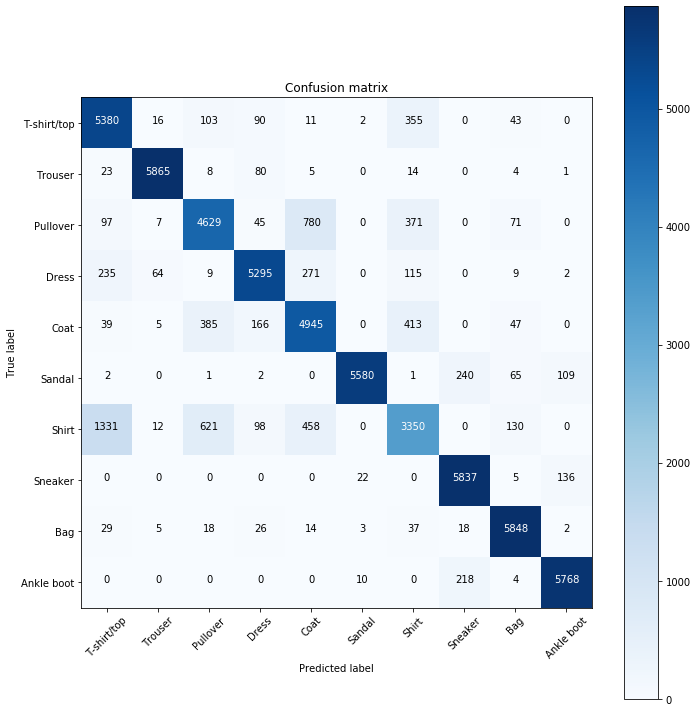

In [35]:
names = (
    'T-shirt/top'
    ,'Trouser'
    ,'Pullover'
    ,'Dress'
    ,'Coat'
    ,'Sandal'
    ,'Shirt'
    ,'Sneaker'
    ,'Bag'
    ,'Ankle boot'
)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, names)